# Crank-Nicolson in 2D

See Sections 9.8 (LOD) & 9.8.2 (ADI) for other methods. 

In this notebook we will develop numerical methods to solve

\begin{align*} \begin{cases} u_t(x,y,t) = u_{xx}(x,y,t) + u_{yy}(x,y,t)\\
u(x,y,0) = \eta(x,y),\\
u(0,y,t) = g_0(y,t),\\
u(1,y,t) = g_1(y,t),\\
u(x,0,t) = h_0(x,t),\\
u(x,1,t) = h_1(x,t). \end{cases} \end{align*}

Using the method of lines, we obtain for $1 \leq i,j \leq m$, $h = 1/(m+1)$,

\begin{align*}
    U'_{i,j}(t) = \frac{ U_{i-1,j}(t) + U_{i+1,j}(t) + U_{i,j-1}(t) + U_{i,j+1}(t) - 4 U_{i,j}(t)}{h^2}.
\end{align*}

Applying the trapezoid method to this we obtain 2D Crank-Nicolson.  If we use forward Euler we obtain (clearly) an explicit method.  The von Neumann stability analysis indicated that this explicit method is stable if

\begin{align*}
    \frac{k}{h^2} \leq \frac{1}{4}.
\end{align*}

We will confirm this to be the case.  If the grid points $(x_i,y_j)$ are arranged by the ordering $\prec$ defined by

\begin{align*}
    (x_{i'},y_{j'}) \prec (x_{i},y_{j}) \quad\text{if}\quad j' < j, \quad \text{and},\\
    (x_{i'},y_{j}) \prec (x_{i},y_{j}) \quad\text{if}\quad i' < i.
\end{align*}

This orders first by the $y$ values and then for a given $y$ value it orders by increasing $x$ value.  This is just the ordering given in Figure 3.2(a).  With this ordering the discrete operator from the MOL approach is given by (3.12):

\begin{align*}
U'(t) = \frac{1}{h^2}A U(t),\quad \text{where} \quad A= \begin{bmatrix}
T  & I\\
I & T & I \\
& I & T & I\\
&& \ddots & \ddots & \ddots \\
&&& I & T \end{bmatrix}, \quad T = \begin{bmatrix}
-4  & 1\\
1 & -4 & 1 \\
& 1 & -4 & 1\\
&& \ddots & \ddots & \ddots \\
&&& 1 & -4 \end{bmatrix}.
\end{align*}

Note that $A$ is an $m^2 \times m^2$ matrix. In our calculations we will have $r = k/h^2$ for the explicit method and $r = k/(2h^2)$ for the implicit method.  With that in mind, we have two important matrices

\begin{align*}
A_l = I - r A, \quad A_r = I + r A.
\end{align*}

And $A_l$ is only used in the implicit methods.

In [1]:
using LinearAlgebra, Plots, Printf, SparseArrays, LaTeXStrings

# The building blocks

1.  Build the grid

In [2]:
h = .01; m = convert(Int64,1/h)-1;
x = Array(h:h:1-h)
y = x
X = repeat(reshape(x, 1, :), length(y), 1)
Y = repeat(reverse(y), 1, length(x))
display(X)
display(Y)

99×99 Matrix{Float64}:
 0.01  0.02  0.03  0.04  0.05  0.06  …  0.94  0.95  0.96  0.97  0.98  0.99
 0.01  0.02  0.03  0.04  0.05  0.06     0.94  0.95  0.96  0.97  0.98  0.99
 0.01  0.02  0.03  0.04  0.05  0.06     0.94  0.95  0.96  0.97  0.98  0.99
 0.01  0.02  0.03  0.04  0.05  0.06     0.94  0.95  0.96  0.97  0.98  0.99
 0.01  0.02  0.03  0.04  0.05  0.06     0.94  0.95  0.96  0.97  0.98  0.99
 0.01  0.02  0.03  0.04  0.05  0.06  …  0.94  0.95  0.96  0.97  0.98  0.99
 0.01  0.02  0.03  0.04  0.05  0.06     0.94  0.95  0.96  0.97  0.98  0.99
 0.01  0.02  0.03  0.04  0.05  0.06     0.94  0.95  0.96  0.97  0.98  0.99
 0.01  0.02  0.03  0.04  0.05  0.06     0.94  0.95  0.96  0.97  0.98  0.99
 0.01  0.02  0.03  0.04  0.05  0.06     0.94  0.95  0.96  0.97  0.98  0.99
 0.01  0.02  0.03  0.04  0.05  0.06  …  0.94  0.95  0.96  0.97  0.98  0.99
 0.01  0.02  0.03  0.04  0.05  0.06     0.94  0.95  0.96  0.97  0.98  0.99
 0.01  0.02  0.03  0.04  0.05  0.06     0.94  0.95  0.96  0.97  0.98  0.99
 ⋮

99×99 Matrix{Float64}:
 0.99  0.99  0.99  0.99  0.99  0.99  …  0.99  0.99  0.99  0.99  0.99  0.99
 0.98  0.98  0.98  0.98  0.98  0.98     0.98  0.98  0.98  0.98  0.98  0.98
 0.97  0.97  0.97  0.97  0.97  0.97     0.97  0.97  0.97  0.97  0.97  0.97
 0.96  0.96  0.96  0.96  0.96  0.96     0.96  0.96  0.96  0.96  0.96  0.96
 0.95  0.95  0.95  0.95  0.95  0.95     0.95  0.95  0.95  0.95  0.95  0.95
 0.94  0.94  0.94  0.94  0.94  0.94  …  0.94  0.94  0.94  0.94  0.94  0.94
 0.93  0.93  0.93  0.93  0.93  0.93     0.93  0.93  0.93  0.93  0.93  0.93
 0.92  0.92  0.92  0.92  0.92  0.92     0.92  0.92  0.92  0.92  0.92  0.92
 0.91  0.91  0.91  0.91  0.91  0.91     0.91  0.91  0.91  0.91  0.91  0.91
 0.9   0.9   0.9   0.9   0.9   0.9      0.9   0.9   0.9   0.9   0.9   0.9
 0.89  0.89  0.89  0.89  0.89  0.89  …  0.89  0.89  0.89  0.89  0.89  0.89
 0.88  0.88  0.88  0.88  0.88  0.88     0.88  0.88  0.88  0.88  0.88  0.88
 0.87  0.87  0.87  0.87  0.87  0.87     0.87  0.87  0.87  0.87  0.87  0.87
 ⋮ 

2. Convert values on the grid to vectors

In [3]:
vals = fill(0.,m,m)
U = map((x,y) -> x + m*(y-1), 1/h*X,1/h*Y)  # construct an enumeration of the grid for testing

99×99 Matrix{Float64}:
 9703.0  9704.0  9705.0  9706.0  9707.0  …  9798.0  9799.0  9800.0  9801.0
 9604.0  9605.0  9606.0  9607.0  9608.0     9699.0  9700.0  9701.0  9702.0
 9505.0  9506.0  9507.0  9508.0  9509.0     9600.0  9601.0  9602.0  9603.0
 9406.0  9407.0  9408.0  9409.0  9410.0     9501.0  9502.0  9503.0  9504.0
 9307.0  9308.0  9309.0  9310.0  9311.0     9402.0  9403.0  9404.0  9405.0
 9208.0  9209.0  9210.0  9211.0  9212.0  …  9303.0  9304.0  9305.0  9306.0
 9109.0  9110.0  9111.0  9112.0  9113.0     9204.0  9205.0  9206.0  9207.0
 9010.0  9011.0  9012.0  9013.0  9014.0     9105.0  9106.0  9107.0  9108.0
 8911.0  8912.0  8913.0  8914.0  8915.0     9006.0  9007.0  9008.0  9009.0
 8812.0  8813.0  8814.0  8815.0  8816.0     8907.0  8908.0  8909.0  8910.0
 8713.0  8714.0  8715.0  8716.0  8717.0  …  8808.0  8809.0  8810.0  8811.0
 8614.0  8615.0  8616.0  8617.0  8618.0     8709.0  8710.0  8711.0  8712.0
 8515.0  8516.0  8517.0  8518.0  8519.0     8610.0  8611.0  8612.0  8613.0
  

In [4]:
tovec(U) = sparsevec(reshape(transpose(U[end:-1:1,:]), m^2, 1))[:]
tovec_a(U) = Array(reshape(transpose(U[end:-1:1,:]), m^2, 1))[:]
tomatrix(Uvec) = transpose(reshape(Uvec,m,m))[end:-1:1,:]

tomatrix (generic function with 1 method)

In [5]:
tovec(U) # The correct enumeration

9801-element SparseVector{Float64, Int64} with 9801 stored entries:
  [1   ]  =  1.0
  [2   ]  =  2.0
  [3   ]  =  3.0
  [4   ]  =  4.0
  [5   ]  =  5.0
  [6   ]  =  6.0
  [7   ]  =  7.0
  [8   ]  =  8.0
  [9   ]  =  9.0
  [10  ]  =  10.0
          ⋮
  [9791]  =  9791.0
  [9792]  =  9792.0
  [9793]  =  9793.0
  [9794]  =  9794.0
  [9795]  =  9795.0
  [9796]  =  9796.0
  [9797]  =  9797.0
  [9798]  =  9798.0
  [9799]  =  9799.0
  [9800]  =  9800.0
  [9801]  =  9801.0

In [6]:
U - tomatrix(tovec(U)) # test that tomatrix is the inverse of tovec

99×99 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

3. Handle the boundary conditions

In [7]:
U

99×99 Matrix{Float64}:
 9703.0  9704.0  9705.0  9706.0  9707.0  …  9798.0  9799.0  9800.0  9801.0
 9604.0  9605.0  9606.0  9607.0  9608.0     9699.0  9700.0  9701.0  9702.0
 9505.0  9506.0  9507.0  9508.0  9509.0     9600.0  9601.0  9602.0  9603.0
 9406.0  9407.0  9408.0  9409.0  9410.0     9501.0  9502.0  9503.0  9504.0
 9307.0  9308.0  9309.0  9310.0  9311.0     9402.0  9403.0  9404.0  9405.0
 9208.0  9209.0  9210.0  9211.0  9212.0  …  9303.0  9304.0  9305.0  9306.0
 9109.0  9110.0  9111.0  9112.0  9113.0     9204.0  9205.0  9206.0  9207.0
 9010.0  9011.0  9012.0  9013.0  9014.0     9105.0  9106.0  9107.0  9108.0
 8911.0  8912.0  8913.0  8914.0  8915.0     9006.0  9007.0  9008.0  9009.0
 8812.0  8813.0  8814.0  8815.0  8816.0     8907.0  8908.0  8909.0  8910.0
 8713.0  8714.0  8715.0  8716.0  8717.0  …  8808.0  8809.0  8810.0  8811.0
 8614.0  8615.0  8616.0  8617.0  8618.0     8709.0  8710.0  8711.0  8712.0
 8515.0  8516.0  8517.0  8518.0  8519.0     8610.0  8611.0  8612.0  8613.0
  

For example, grid points $1,2,\ldots,m$ are connected to $h_0(x,t)$ and grid points $1,m+1,2m+1,\ldots$ are connected to $g_0(y,t)$. 

In [9]:
# not actually used -- the inverse of v_location
function bc_location(j::Int64,m1::Int64)
    row = convert(Int64,floor((j-1)/m1) + 1)
    col = j - (row-1)*m1
    (row,col)
end

function v_location(p,m) # p = (row, col)
    return (p[1]-1)*m+p[2] # basically the same function used to create the test grid U
end

function pos_gen(m)
    h0pos = map(t -> v_location(t,m), [(1,i) for i in 1:m]) # along the bottom boundary, h0
    h1pos = map(t -> v_location(t,m), [(m,i) for i in 1:m]) # along the top boundary, h1
    g0pos = map(t -> v_location(t,m), [(i,1) for i in 1:m]) # g0
    g1pos = map(t -> v_location(t,m), [(i,m) for i in 1:m]) # g1
    pos = [];
    append!(pos,h0pos)
    append!(pos,h1pos)
    append!(pos,g0pos)
    append!(pos,g1pos)
    pos
end    

pos_gen (generic function with 1 method)

In [ ]:
pos

In [10]:
pos = pos_gen(m)
pos[1:m] |> display # locations for h0(x,t), increasing x
pos[m+1:2m] |> display# locations for h1(x,t)
pos[2m+1:3m] |> display # locations for g0(y,t), increasing y
pos[3m+1:end] |> display # locations for g1(y,t)

99-element Vector{Any}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
  ⋮
 88
 89
 90
 91
 92
 93
 94
 95
 96
 97
 98
 99

99-element Vector{Any}:
 9703
 9704
 9705
 9706
 9707
 9708
 9709
 9710
 9711
 9712
 9713
 9714
 9715
    ⋮
 9790
 9791
 9792
 9793
 9794
 9795
 9796
 9797
 9798
 9799
 9800
 9801

99-element Vector{Any}:
    1
  100
  199
  298
  397
  496
  595
  694
  793
  892
  991
 1090
 1189
    ⋮
 8614
 8713
 8812
 8911
 9010
 9109
 9208
 9307
 9406
 9505
 9604
 9703

99-element Vector{Any}:
   99
  198
  297
  396
  495
  594
  693
  792
  891
  990
 1089
 1188
 1287
    ⋮
 8712
 8811
 8910
 9009
 9108
 9207
 9306
 9405
 9504
 9603
 9702
 9801

In [11]:
function boundary(x::Vector{Float64},y::Vector{Float64},t::Float64,pos::Vector)
    bcvec = Array{Float64}([]);
    append!(bcvec,h0(x,t))
    append!(bcvec,h1(x,t))
    append!(bcvec,g0(y,t))
    append!(bcvec,g1(y,t))
    sparsevec(pos,bcvec)
    #Array(sparsevec(pos,bcvec))
end

boundary (generic function with 1 method)

In [12]:
h0 = (x,t) -> 1. .+ 0*x
h1 = (x,t) -> -1. .+ 0*x
g0 = (y,t) -> 2. .+ 0*y
g1 = (y,t) -> -2. .+ 0*y
U = boundary(x,y,0.,pos)
tomatrix(U) |> Array

99×99 Matrix{Float64}:
 1.0  -1.0  -1.0  -1.0  -1.0  -1.0  …  -1.0  -1.0  -1.0  -1.0  -1.0  -3.0
 2.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0  -2.0
 2.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0  -2.0
 2.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0  -2.0
 2.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0  -2.0
 2.0   0.0   0.0   0.0   0.0   0.0  …   0.0   0.0   0.0   0.0   0.0  -2.0
 2.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0  -2.0
 2.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0  -2.0
 2.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0  -2.0
 2.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0  -2.0
 2.0   0.0   0.0   0.0   0.0   0.0  …   0.0   0.0   0.0   0.0   0.0  -2.0
 2.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0  -2.0
 2.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0  -2.0
 ⋮             

4. Construct $A$

In [13]:
A₀ = SymTridiagonal{Float64}(fill(-4.0,m),fill(1,m-1))
A = spzeros(m^2,m^2)
for j = 1:m
    A[m*(j-1)+1:m*j,m*(j-1)+1:m*j] += A₀
end
for j = 1:m-1
    A[m*(j-1)+1:m*j,m*(j)+1:m*(j+1)] += I
    A[m*(j)+1:m*(j+1),m*(j-1)+1:m*(j)] += I
end
A |> Array

9801×9801 Matrix{Float64}:
 -4.0   1.0   0.0   0.0   0.0   0.0  …   0.0   0.0   0.0   0.0   0.0   0.0
  1.0  -4.0   1.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   1.0  -4.0   1.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   1.0  -4.0   1.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   1.0  -4.0   1.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   1.0  -4.0  …   0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   1.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0  …   0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.

4. Initial/boundary data and plotting helper 

In [16]:
bcfun = (x,y,t) -> t/(1 + t)*exp.(x.*y)*(sin(10*t)^2).+0.3
g0 = (y,t) -> bcfun(0.0,y,t)
g1 = (y,t) -> bcfun(1.0,y,t)
h0 = (x,t) -> bcfun(x,0.0,t)
h1 = (x,t) -> bcfun(x,1.0,t)
η = (x,y) -> 2*y.*x.*exp.(-30*(2*(x .- 0.5).^2 .+ (y .- 0.5).^2)).+0.3

function plot_heat(U,x,y,t,cl,width=800)
    p1 = surface(x, y, U[end:-1:1,:], zaxis = [cl[1],cl[2]], clims= cl, aspectratio = .6, xlabel = L"x", ylabel = L"y", zlabel = L"u(x,y,t)")
    p2 = contour(x, y, U[end:-1:1,:], clims=cl, xaxis = [0,1], yaxis = [0,1], fill = true, aspectratio = 1, xlabel = L"x", ylabel = L"y")
    plot(p1, p2, layout = 2, size = (width, 7*width/10), title = @sprintf("t = %1.4f",t))
end

plot_heat (generic function with 2 methods)

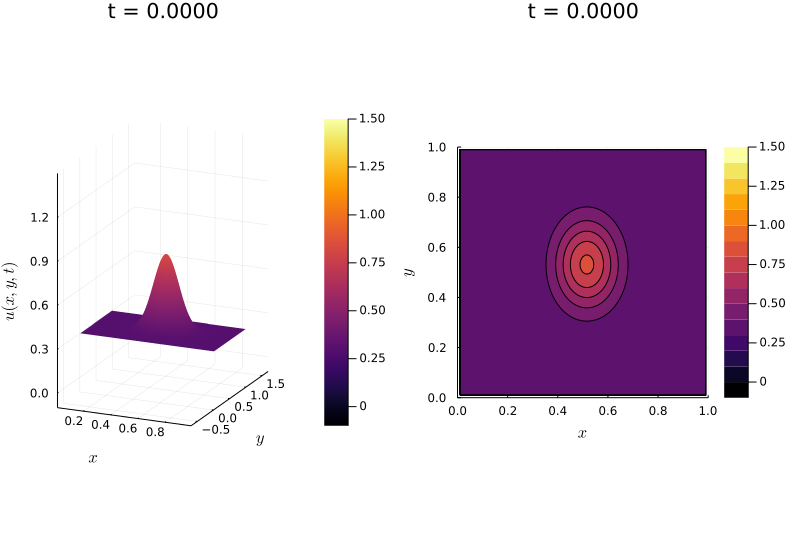

In [17]:
U⁰ = η(X,Y)
plot_heat(U⁰,x,y,0.0,(-0.1,1.5))

## An actual run

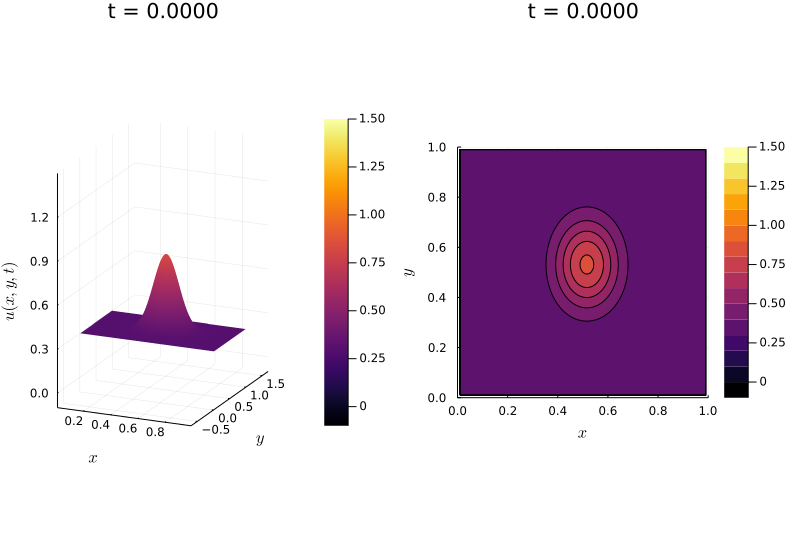

In [18]:
h = .01; m = convert(Int64,1/h)-1;
x = Array(h:h:1-h)
y = x
X = repeat(reshape(x, 1, :), length(y), 1)
Y = repeat(reverse(y), 1, length(x))
U⁰ = η(X,Y)
plot_heat(U⁰,x,y,0.0,(-0.1,1.5))

## Test stability with explicit method

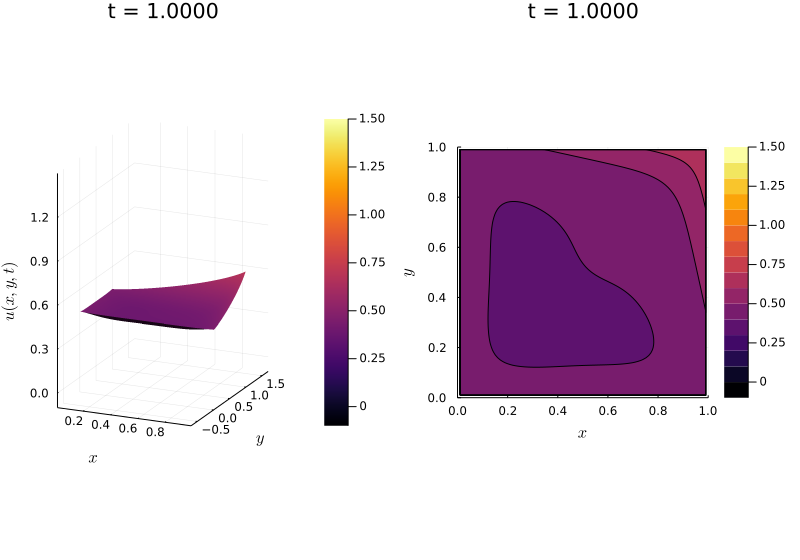

In [19]:
h = .01; k = h^2/4; T = 1;  #On the stability boundary
m = convert(Int64,1/h)-1;
n = convert(Int64,ceil(T/k))

A₀ = SymTridiagonal{Float64}(fill(-4.0,m),fill(1,m-1))
A = spzeros(m^2,m^2)
for j = 1:m
    A[m*(j-1)+1:m*j,m*(j-1)+1:m*j] += A₀
end
for j = 1:m-1
    A[m*(j-1)+1:m*j,m*(j)+1:m*(j+1)] += I
    A[m*(j)+1:m*(j+1),m*(j-1)+1:m*(j)] += I
end
r = k/(h^2)
x = Array(h:h:1-h)
y = x
X = repeat(reshape(x, 1, :), length(y), 1)
Y = repeat(reverse(y), 1, length(x))
U⁰ = η(X,Y)
Ar = I + r*A;
pos = pos_gen(m)

U = tovec(U⁰)
t = 0
fr = 100 #frames/unit time
tb = convert(Int64,ceil(n/(fr*T)))
for i = 2:n+1
    t += k
    U = Ar*U
    U += r*boundary(x,y,t,pos)
    if mod(i-1,tb) ≈ 0.0
        IJulia.clear_output(true)
        plot_heat(tomatrix(U),x,y,t,(-0.1,1.5)) |> IJulia.display
    end
end

In [20]:
h = .01; k = h^2/4*(1.001); T = .64;  #Just beyond the stability boundary
m = convert(Int64,1/h)-1;
n = convert(Int64,ceil(T/k))

A₀ = SymTridiagonal{Float64}(fill(-4.0,m),fill(1,m-1))
A = spzeros(m^2,m^2)
for j = 1:m
    A[m*(j-1)+1:m*j,m*(j-1)+1:m*j] += A₀
end
for j = 1:m-1
    A[m*(j-1)+1:m*j,m*(j)+1:m*(j+1)] += I
    A[m*(j)+1:m*(j+1),m*(j-1)+1:m*(j)] += I
end
r = k/(h^2)
x = Array(h:h:1-h)
y = x
X = repeat(reshape(x, 1, :), length(y), 1)
Y = repeat(reverse(y), 1, length(x))
U⁰ = η(X,Y)
Ar = I + r*A;
pos = pos_gen(m)

U = tovec(U⁰)
t = 0
fr = 100 #frames/unit time
tb = convert(Int64,ceil(n/(fr*T)))
for i = 2:n+1
    t += k
    U = Ar*U
    U += r*boundary(x,y,t,pos)
    if mod(i-1,tb) ≈ 0.0
        IJulia.clear_output(true)
        plot_heat(tomatrix(U),x,y,t,(-0.1,1.5)) |> IJulia.display
    end
end

## The implicit method

We need an implementation of the conjugate gradient algorithm.  We could be using the locally one dimensional (LOD) or the alternating direction implicit (ADI) methods.  But I wanted to show you how one would incorporate an iterative method for sparse systems into a PDE solver.

In [21]:
function CG(A,b,x,eps,flag = false)
   r = b - A*x; p = r; n = 0
   while norm(r) > eps
        q = A*p
        a = (r'*r)/(p'*q)
        x = x + a*p
        r_old = r
        r = r - a*q
        b = (r'*r)/(r_old'*r_old)
        p = r + b*p 
        n += 1
    end
    if flag
        @printf("Iteration count = %i \n",n)
    end
    x
end

CG (generic function with 2 methods)

In [22]:
h = .01; k = .01; T = 2;
m = convert(Int64,1/h)-1;
n = convert(Int64,ceil(T/k))

A₀ = SymTridiagonal{Float64}(fill(-4.0,m),fill(1,m-1))
A = spzeros(m^2,m^2)
for j = 1:m
    A[m*(j-1)+1:m*j,m*(j-1)+1:m*j] += A₀
end
for j = 1:m-1
    A[m*(j-1)+1:m*j,m*(j)+1:m*(j+1)] += I
    A[m*(j)+1:m*(j+1),m*(j-1)+1:m*(j)] += I
end
r = k/(2*h^2)
x = Array(h:h:1-h)
y = x
X = repeat(reshape(x, 1, :), length(y), 1)
Y = repeat(reverse(y), 1, length(x))
Al = I - r*A; Ar = I + r*A;
pos = pos_gen(m);

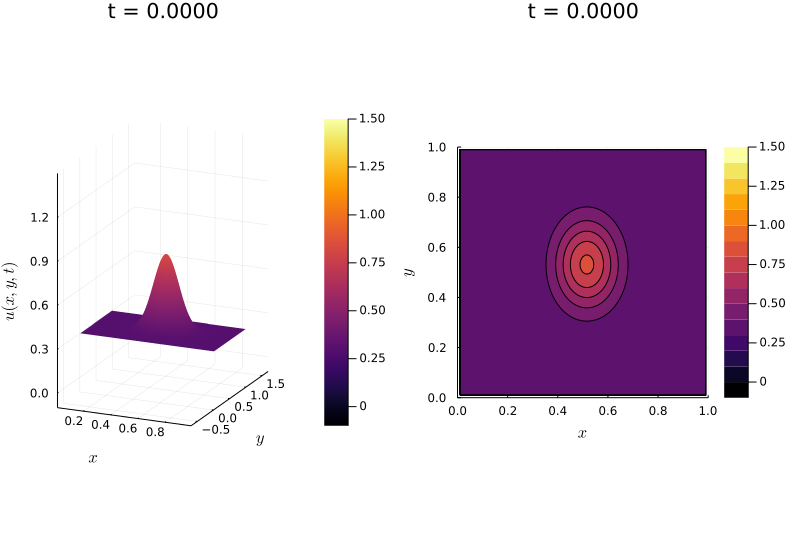

In [23]:
U⁰ = η(X,Y)
plot_heat(U⁰,x,y,0.0,(-0.1,1.5))

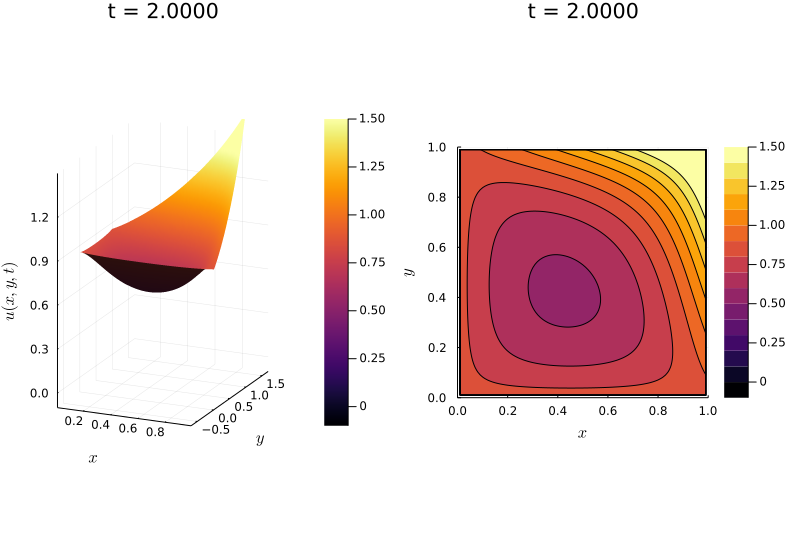

In [24]:
U = tovec(U⁰)
t = 0
fr = 100 #frames/unit time
tb = convert(Int64,ceil(n/(fr*T)))
for i = 2:n+1
    t += k
    Uold = U
    U = Ar*U
    U += r*(boundary(x,y,t,pos)+boundary(x,y,t-k,pos))
    U = CG(Al,U,Uold,0.00001) #Al\U
    if mod(i-1,tb) ≈ 0.0
        IJulia.clear_output(true)
        plot_heat(tomatrix(U),x,y,t,(-0.1,1.5)) |> IJulia.display
    end
end

In [ ]:
U⁰ = η(X,Y)
U = tovec(U⁰)
sol = CG(Al,Ar*U,U,0.00001,true)
Al*sol - Ar*U |> norm

## Preconditioning?

In [ ]:
off_diag = fill(1.0,m^2-1)
for i = m:m:m^2-1
    off_diag[i] = 0.
end
Ap = SymTridiagonal{Float64}(fill(-2,m^2),off_diag)
Ap[1:20,1:20] |> Array |> display
Ap = I - (r/4)*Ap;

In [ ]:
## When A = Ap this will first "do" heat flow in the x-direction and then in y-direction.
function pre(A::SymTridiagonal{Float64,Array{Float64,1}},x::SparseVector{Float64,Int64})
    tovec(transpose(tomatrix(A\tovec_a(transpose(tomatrix(A\Array(x)))))))
end

function CG_pre(A::SparseMatrixCSC{Float64,Int64},M::Function,b::SparseVector{Float64,Int64},x::SparseVector{Float64,Int64},eps::Float64,flag = false)
   r = b - A*x; n = 0; z = M(r);  p = z;
   while norm(r) > eps
        q = A*p
        a = (r'*z)/(p'*q)
        x = x + a*p
        r_old = r
        z_old = z
        r = r - a*q
        z = M(r)
        b = (r'*z)/(r_old'*z_old)
        p = z + b*p 
        n += 1
    end
    if flag
        @printf("Iteration count = %i \n",n)
    end 
    x
end

In [ ]:
U⁰ = η(X,Y)
U = tovec(U⁰)
@time sol = CG_pre(Al,x -> pre(Ap,x),Ar*U,U,0.0000001,true)
Al*sol - Ar*U |> norm

In [ ]:
U⁰ = η(X,Y)
U = tovec(U⁰)
@time sol = CG(Al,Ar*U,U,0.0000001,true)
Al*sol - Ar*U |> norm

In [ ]:
h = .01; k = .01; T = 1.;
m = convert(Int64,1/h)-1;
n = convert(Int64,ceil(T/k))

A₀ = SymTridiagonal{Float64}(fill(-4.0,m),fill(1,m-1))
A = spzeros(m^2,m^2)
for j = 1:m
    A[m*(j-1)+1:m*j,m*(j-1)+1:m*j] += A₀
end
for j = 1:m-1
    A[m*(j-1)+1:m*j,m*(j)+1:m*(j+1)] += I
    A[m*(j)+1:m*(j+1),m*(j-1)+1:m*(j)] += I
end
r = k/(2*h^2)
x = Array(h:h:1-h)
y = x
X = repeat(reshape(x, 1, :), length(y), 1)
Y = repeat(reverse(y), 1, length(x))
Al = I - r*A; Ar = I + r*A;
pos = pos_gen(m)

# Setup tridiagonal preconditioner
off_diag = fill(1.0,m^2-1)
for i = m:m:m^2-1
    off_diag[i] = 0.
end
Ap = SymTridiagonal{Float64}(fill(-2,m^2),off_diag)
Ap = I - (r/4)*Ap;

U = tovec(U⁰)
t = 0
fr = 100 #frames/unit time
tb = convert(Int64,ceil(n/(fr*T)))
for i = 2:n+1
    t += k
    Uold = U
    U = Ar*U
    U += r*(boundary(x,y,t,pos)+boundary(x,y,t-k,pos))
    U = CG_pre(Al, x-> pre(Ap,x),U,Uold,0.00001)
    if mod(i-1,tb) ≈ 0.0
        IJulia.clear_output(true)
        plot_heat(tomatrix(U),x,y,t,(-0.1,1.5)) |> IJulia.display
    end
end

## Timings

In [ ]:
h = .01; k = .01; T = 1.;
m = convert(Int64,1/h)-1;
n = convert(Int64,ceil(T/k))

A₀ = SymTridiagonal{Float64}(fill(-4.0,m),fill(1,m-1))
A = spzeros(m^2,m^2)
for j = 1:m
    A[m*(j-1)+1:m*j,m*(j-1)+1:m*j] += A₀
end
for j = 1:m-1
    A[m*(j-1)+1:m*j,m*(j)+1:m*(j+1)] += I
    A[m*(j)+1:m*(j+1),m*(j-1)+1:m*(j)] += I
end
r = k/(2*h^2)
x = Array(h:h:1-h)
y = x
X = repeat(reshape(x, 1, :), length(y), 1)
Y = repeat(reverse(y), 1, length(x))
Al = I - r*A; Ar = I + r*A;
pos = pos_gen(m)

# Setup tridiagonal preconditioner
off_diag = fill(1.0,m^2-1)
for i = m:m:m^2-1
    off_diag[i] = 0.
end
Ap = SymTridiagonal{Float64}(fill(-2,m^2),off_diag)
Ap = I - (r/4)*Ap;
U⁰ = η(X,Y);

In [ ]:
function with_prec()
    U = tovec(U⁰)
    t = 0
    for i = 2:n+1
        t += k
        Uold = U
        U = Ar*U
        U += r*(boundary(x,y,t,pos)+boundary(x,y,t-k,pos))
        U = CG_pre(Al, x-> pre(Ap,x),U,Uold,0.00001)
    end
end

function without_prec()
    U = tovec(U⁰)
    t = 0
    for i = 2:n+1
        t += k
        Uold = U
        U = Ar*U
        U += r*(boundary(x,y,t,pos)+boundary(x,y,t-k,pos))
        U = CG(Al,U,Uold,0.00001)
    end
end

In [ ]:
@time with_prec()
@time without_prec()

### Create a gif with a high framerate

In [ ]:
h = .01; k = .001; T = 2.;
m = convert(Int64,1/h)-1;
n = convert(Int64,ceil(T/k))

A₀ = SymTridiagonal{Float64}(fill(-4.0,m),fill(1,m-1))
A = spzeros(m^2,m^2)
for j = 1:m
    A[m*(j-1)+1:m*j,m*(j-1)+1:m*j] += A₀
end
for j = 1:m-1
    A[m*(j-1)+1:m*j,m*(j)+1:m*(j+1)] += I
    A[m*(j)+1:m*(j+1),m*(j-1)+1:m*(j)] += I
end
r = k/(2*h^2)
x = Array(h:h:1-h)
y = x
X = repeat(reshape(x, 1, :), length(y), 1)
Y = repeat(reverse(y), 1, length(x))
Al = I - r*A; Ar = I + r*A;
pos = pos_gen(m)

# Setup tridiagonal preconditioner
off_diag = fill(1.0,m^2-1)
for i = m:m:m^2-1
    off_diag[i] = 0.
end
Ap = SymTridiagonal{Float64}(fill(-2,m^2),off_diag)
Ap = I - r*Ap;
U⁰ = η(X,Y);

plot()
anim = Animation()
U = tovec(U⁰)
t = 0
plot_heat(tomatrix(U),x,y,0.0,(-0.1,1.5))
frame(anim)
fr = 1000 #frames/unit time
tb = convert(Int64,ceil(n/(fr*T)))
for i = 2:n+1
    t += k
    Uold = U
    U = Ar*U
    U += r*(boundary(x,y,t,pos)+boundary(x,y,t-k,pos))
    U = CG_pre(Al, x-> pre(Ap,x),U,Uold,0.00001)
    if mod(i-1,tb) ≈ 0.0
        #IJulia.clear_output(true)
        plot_heat(tomatrix(U),x,y,t,(-0.1,1.5))
        frame(anim)
    end
end
gif(anim,"heat_2D_CN.gif")